# Processing of gravitational data
In this notebook we will apply some signal processing to the gravitational data. Preprocessing is definately required on these signals, and thankfully there is a Python package called [GWpy](https://gwpy.github.io/docs/latest/index.html) that has all functions that are needed. Theory will not be discussed here in detail, but there is plenty of info and code on the topic:   
  * [GW tutorials](https://www.gw-openscience.org/tutorials/)
  * [Gravitational Wave Open Science Center](https://www.gw-openscience.org/software/)
  * [A guide to LIGO–Virgo detector noise and extraction of transient gravitational-wave signals](https://iopscience.iop.org/article/10.1088/1361-6382/ab685e)
  
  
First, install GWpy:

In [1]:
!python -m pip install gwpy
!pip install astropy==4.2.1

     |████████████████████████████████| 1.4 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 45 kB 2.7 MB/s  eta 0:00:01
     |████████████████████████████████| 10.7 MB 346 kB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 50.3 MB/s eta 0:00:01
     |████████████████████████████████| 734 kB 64.9 MB/s eta 0:00:01
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp37-cp37m-linux_x86_64.whl size=92896 sha256=b35c480fd94d53b29eba0efc79f63839611c8794845484bd27575852b54375e5
  Stored in directory: /root/.cache/pip/wheels/09/f9/d4/129b3bb4458d50b56fdc8245ace7c8216d54865fe8d3aebc05
Successfully built ligo-segments
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

And import a few libraries.

In [2]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from matplotlib import pyplot as plt

# Read & plot files
Let's define helper function to read numpy data and convert into GWpy TimeSeries format and plot the data. All the files are 2s recordings at 2048Hz sample rate from the 3 detectors.

In [16]:
def read_file(fname):
    data = np.load(fname)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3

def plot_time_data(d1, d2, d3):
    plot = Plot(d1, d2, d3, separate=True, sharex=True, figsize=[12, 10])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()

Visualize a file:

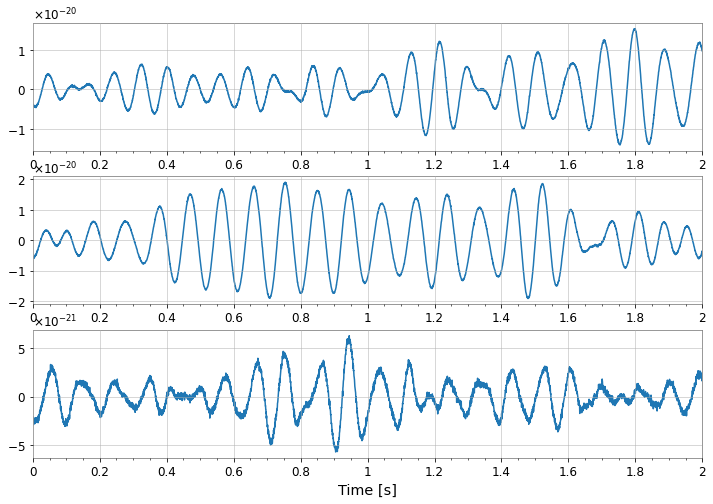

In [4]:
d1, d2, d3 = read_file('../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy')
plot_time_data(d1, d2, d3)

# Preprocess
Then we will follow the general processing steps outlined in [this article](https://iopscience.iop.org/article/10.1088/1361-6382/ab685e):  
* Apply a window function (Tukey - tapered cosine window) to suppress spectral leakage
* Whiten the spectrum
* Bandpass

## Apply window function

The Tukey window looks like this:

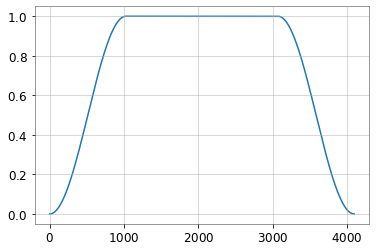

In [5]:
window = signal.tukey(4096)
plt.plot(window);

Let's look at the signal after windowing:

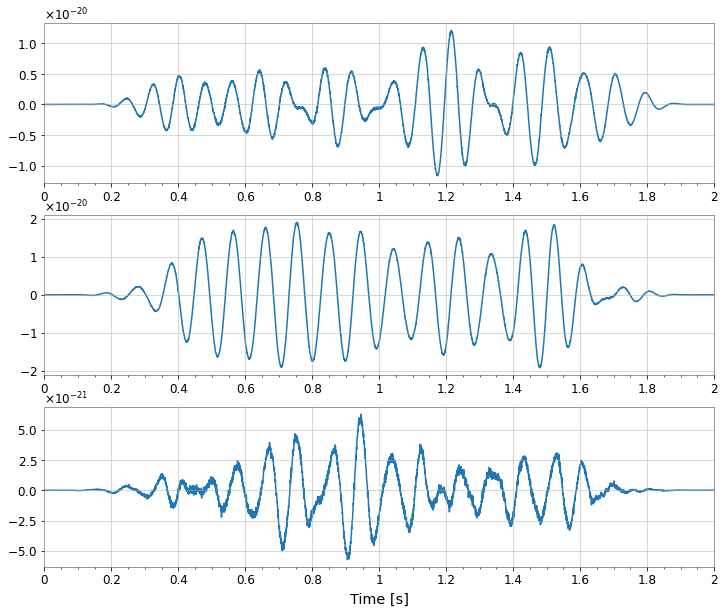

In [17]:
d1, d2, d3 = d1*window, d2*window, d3*window
plot_time_data(d1, d2, d3)

Take a look at the spectrum - there is a lot of low frequency noise:

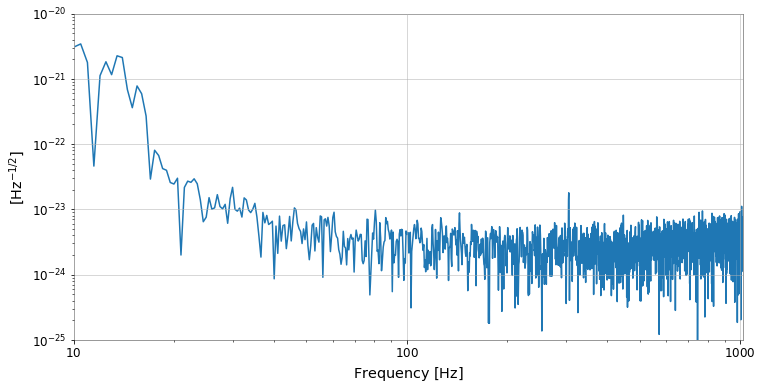

In [7]:
fig2 = d1.asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

We can easily highpass the data (here with 15Hz highpass frequency):

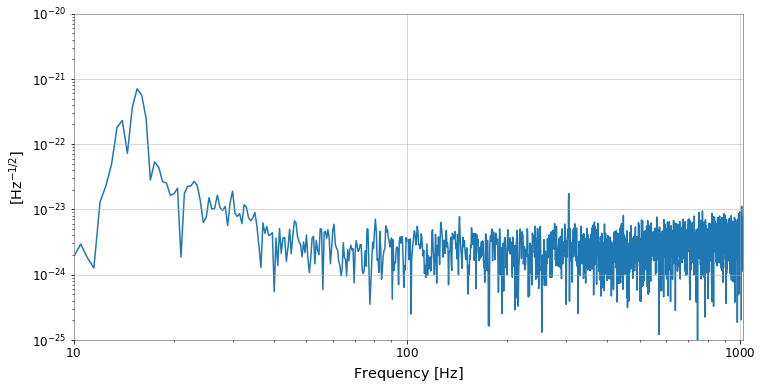

In [8]:
fig2b = d1.highpass(15).asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

## Spectral whitening and bandpass filtering
This is super simple with GWpy:

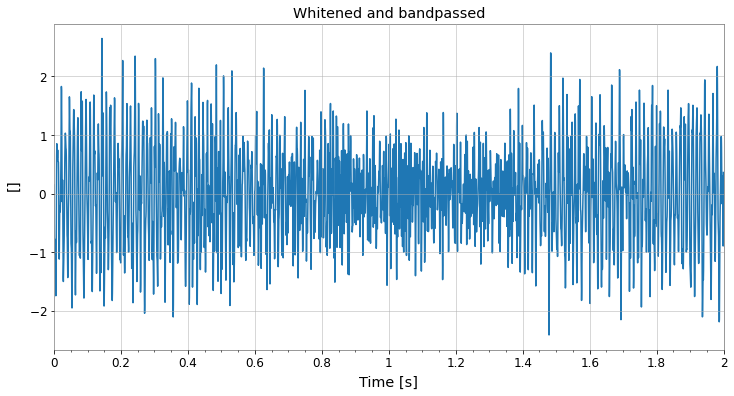

In [15]:
white_data = d1.whiten(window=("tukey",0.2)) # whiten-function has a built-in window function
bp_data = white_data.bandpass(35, 350) # frequency range 35-350Hz
fig3 = bp_data.plot(figsize=[12, 6])
plt.xlim(0, 2)
ax = plt.gca()
ax.set_title('Whitened and bandpassed')
ax.set_xlabel('Time [s]');

Now, we have a preprocessed data that is ready for further analysis. First, let's define a function that combines all the steps above and outputs preprocessed data:

In [10]:
def preprocess(d1, d2, d3, bandpass=False, lf=35, hf=350):
    white_d1 = d1.whiten(window=("tukey",0.2))
    white_d2 = d2.whiten(window=("tukey",0.2))
    white_d3 = d3.whiten(window=("tukey",0.2))
    if bandpass: # bandpass filter
        bp_d1 = white_d1.bandpass(lf, hf) 
        bp_d2 = white_d2.bandpass(lf, hf)
        bp_d3 = white_d3.bandpass(lf, hf)
        return bp_d1, bp_d2, bp_d3
    else: # only whiten
        return white_d1, white_d2, white_d3

# Q-Transform
The Q-Transform is related to the Fourier transform, and very closely related to a wavelet transform. The spectrogram is a possible candidate as input for a CNN model.

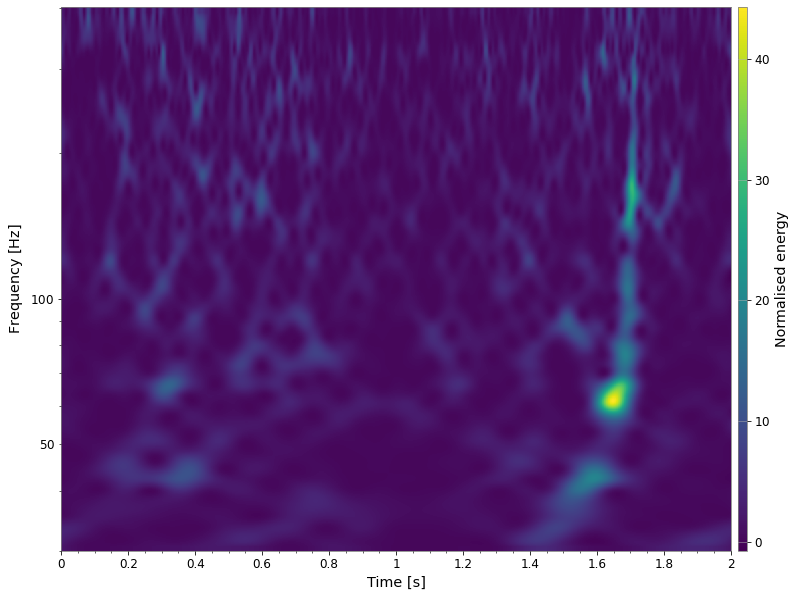

In [11]:
r1, r2, r3 = read_file('../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy') # this signal has target=1
p1, p2, p3 = preprocess(r1, r2, r3)
hq = p2.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
fig4 = hq.plot(figsize=[12, 10])
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Time [s]');

## Combine three channels into one RGB image
Since we have 3 detectors, we can combine the Q-Transforms as RGB channels into one color image. Let's make a function for that:

In [12]:
Q_RANGE = (16,32)
F_RANGE = (30,400)

def create_rgb(fname):
    r1, r2, r3 = read_file(fname)
    p1, p2, p3 = preprocess(r1, r2, r3)
    hq1 = p1.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq2 = p2.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    hq3 = p3.q_transform(qrange=Q_RANGE, frange=F_RANGE, logf=True, whiten=False)
    img = np.zeros([hq1.shape[0], hq1.shape[1], 3], dtype=np.uint8)
    scaler = MinMaxScaler()
    img[:,:,0] = 255*scaler.fit_transform(hq1)
    img[:,:,1] = 255*scaler.fit_transform(hq2)
    img[:,:,2] = 255*scaler.fit_transform(hq3)
    return Image.fromarray(img).rotate(90, expand=1).resize((760,760))

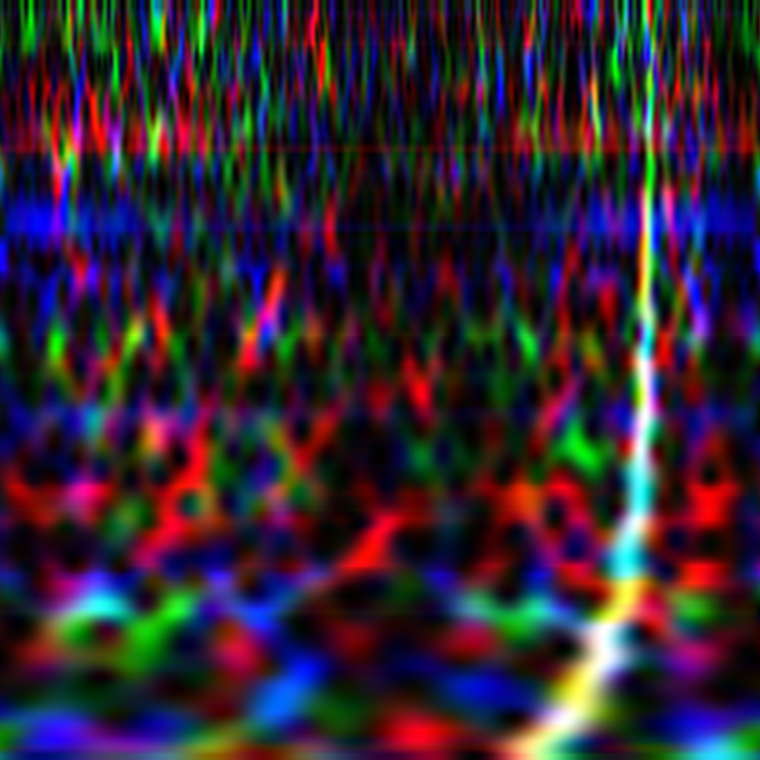

In [13]:
create_rgb('../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy')

Here is a very obvious one (chirp) from the test set:

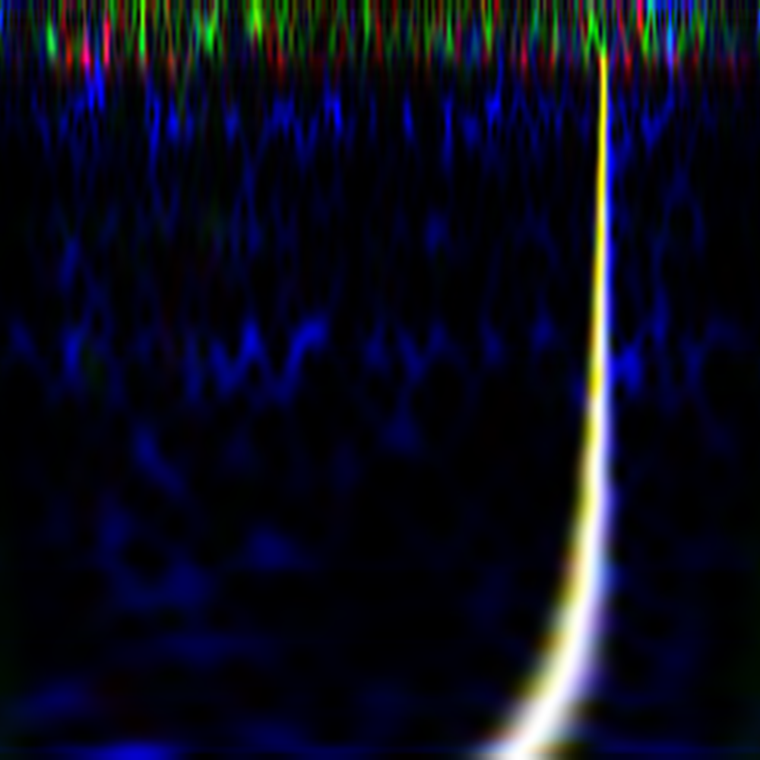

In [14]:
create_rgb('../input/g2net-gravitational-wave-detection/test/0/0/2/0021f9dd71.npy')

Awesome! (Or crazy?) Next step is to find out if we can train an image classifier with these images...